[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

## Brief theory of addition

### Importance

Binary addition is one of the most used and important operations in computing. 

For example, when booting a RISC-V processor into Linux over 2/3rds of the assembly instructions will use addition in some manner.

Optimizing adder hardware affects entire designs.

### Breakdown of addition

Binary addition has a "local" and "non-local" component.<br>
Take the following example:

      999 999 +
      000 001
      _______
    1 000 000

Each digit of the sum depends "locally" on the corresponding digits of each input.<br>
But all digits of the sum also depend "non-locally" on all digits to the right.
The $1$ on the far right affects even the left-most digit of the result.

In math terms, for $s = a+b$, the digit $s_i$ depends locally on $a_i$ and $b_i$, and non-locally on all $a_j, b_j$ where $i > j \geq 0$.

The local aspect of binary addition can be resolved in parallel, in a single time-step, for every digit.<br>
Again, $s_i$ depends locally only on $a_i$ and $b_i$. For an $n$-bit adder, just instantiate $n$ copies of the hardware, and process all bits of $a$ and $b$ at the same time.

The non-local aspect is more complex. The naïve grade-school implementation of adding one digit at a time and "carrying over the one" uses $n$ time-steps. Speeding it up by doing two digits at a time can reduce that to $n/2$ time-steps, but that's still **O(n)**.

**O(n)** is very slow. **O(lg n)** on the other hand is both fast and achievable.

## Brief theory of arithmetic operations

### Arithmetic computation in logarithmic time

An extensive body of literature provides a three-step recipe for speeding up non-local aspects of a computation.

1.   Express the non-local computation of digit $i$ as $Y_i = X_i ■ Y_{i-1} $.<br>
$Y$ is the output, $X$ is the input, $■$ is some pre-determined operator.
2.   Expand: $Y_i = X_i ■ X_{i-1} ■ X_{i-2} ■ \dots X_0$.<br>
Clearly this is a non-local computation: every output depends on all previous inputs, in some manner that is determined by $■$.
3.   Associate: $Y_i = (X_i ■ X_{i-1}) ■ (X_{i-2} ■ \dots X_0)$

The expression in step #2 takes $i-1$ steps. The expression in step #3 can take anywhere from $lg(i)$ to $i-1$ steps, depending on how association is performed.

For a concrete example, compare the following 7-step operation:

$Y_7 = X_7 ■ (X_6 ■ (X_5 ■ (X_4 ■ (X_3 ■ (X_2 ■ (X_1 ■ X_0))))))$

To a 3-step alternative:

$Y_7 = (((X_7 ■ X_6) ■ (X_5 ■ X_4)) ■ ((X_3 ■ X_2) ■ (X_1 ■ X_0)))$

### What is ■?

There's a simple recipe to determine ■ for any arithmetic operation, over which I am currently writing a paper.

It is outside the scope of this notebook.

Here is ■ for addition, expressed as a CMOS logic schematic:

![](https://drive.google.com/uc?export=view&id=1O0v4RCn8GlN10Adtne98e0Ir0CU-Goqg)

### Wait, what about the local component??

The local component of any arithmetic operation can also be determined from a simple recipe.

It is less interesting than the non-local component since there is only one way to handle it within a single clock-cycle: instantiate $n$ copies of the hardware and perform all the local computations in parallel in a single time-step.

Typically the local component is calculated separately, then combined with the non-local component at the very end of the operation to yield the final result.

Here is the local component for addition, expressed as a CMOS logic schematic:

![](https://drive.google.com/uc?export=view&id=1MU_f2ygcCtwKwXS4loRUNsGU1ZL3Ksmc)

### How many ways can you associate an expression?

An expression of $n$ terms such as the one above can be associated in $C_n$ ways, where $C$ represents the Catalan numbers.

What else do the Catalan numbers represent? The number of ways different ways to draw a binary tree with $n+1$ leafs.

That means that all such arithmetic circuits can be mapped to and from binary trees.

See the demo section for a full demo, or see below for a preview:

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git to /tmp/pip-req-build-whz8wf6m
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-whz8wf6m


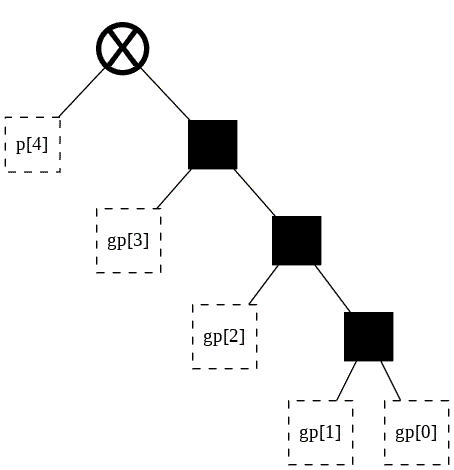

In [ ]:
from pptrees.AdderTree import AdderTree as tree
from pptrees.util import catalan
from pptrees.util import display_gif
from IPython.display import Image

possible_trees = []
width = 5
for a in range(catalan(width-1)):
  possible_trees.append(tree(width, start_point=a))

Image(display_gif(possible_trees))

### Why is this huge design space relevant at all?

In software, a balanced tree with $lg(n)$ height is often optimal.<br>
In hardware, the sacrifices needed to balance a tree to $lg(n)$ height can outweigh the benefits.<br>Sometimes it is actually faster to use a circuit that performs more sequential operations back-to-back.

This will be explained in detail over the course of the next section.

## Classic hardware addition

### Trees calculate one digit of the answer. What calculates the whole thing?

The previous section discussed the calculation of a single digit of the final answer and showed that it could be represented as a binary tree.

How then can the entire of the final answer be represented, with all of its digits?

Clasically, this is done through a tree with multiple roots, one for each digit. This structure is known as a polytree, or an $n$-rooted tree.

### Classic structures

This section presents several classic adder structures.

The diagrams shown below are drawn in the classic style of adder literature.

Data flows from top to bottom. Thus the $n$ roots of the tree sit at the bottom.<br>
Nodes labeled "pre" perform pre-processing logic that encodes $a$ and $b$ into an alternate form.<br>
Nodes labeled "post" re-compose the local and non-local aspects of binary addition into the final sum.<br>
The main body of the diagrams performs the non-local computation.

### Serial structure

![](https://drive.google.com/uc?export=view&id=13e1lmN7klllqSQP6t6qYmQ6x01t_Gn0M)

This is the naïve implementation of adding one digit at a time and "carrying over the one".

### Sklansky structure

![](https://drive.google.com/uc?export=view&id=1WCUiqWeJ9TXQusRjzz5H60joxLAlL9yj)

This is a right-balanced tree.

The height of the tree (the number of sequential logic levels) has dropped from $n-1$ to $lg(n)$, thus decreasing the delay.

The number of nodes has risen, thus increasing both area and power consumption.

However, it may be observed that some nodes drive multiple outputs.<br>
This is a concept known as **fanout**.<br>
Fanout directly increases delay.

![](https://drive.google.com/uc?export=view&id=1pgwApT1IHbxymlVcvxmQjUUvpN2GR86N)

### Kogge-Stone structure

![](https://drive.google.com/uc?export=view&id=1ub-slSzP-g6Ggpj32Bk-59dVexpivcIK)

This is a left-balanced tree.

It can be seen to have minimal fanout. As such, it should be faster than the previous structure.

The height of the tree (the number of sequential logic levels) remains at $lg(n)$, thus decreasing the delay.

The number of nodes has risen, thus increasing both area and power consumption.

However, it may be observed that some of the gaps between the rows of nodes have multiple sets of parallel wires running through them.<br>
This concept is known as wire **tracks**.<br>
An increased need for wire tracks also directly increases the delay. Either the wires are placed in close proximity, and cross-coupling capacitance degrades performance, or the wires are spaced out, and the electrical signal has to deal with longer wires.

### Brent-Kung structure

![](https://drive.google.com/uc?export=view&id=1XY1FaMYyqFiK6ViAHSf9Ueq4-3LE0JIS)

This is a tree with both minimal fanout as well as minimum wire tracks.

However, the number of logic **levels** is higher than both previous examples, at $2lg(n)-1$.

### Trade-offs (layers, fan-out, tracks)

The previous section asked "Why is this huge design space relevant at all?"<br>
These necessary trade-offs, between layers, fan-out, and tracks, is why the design space must be explored.

While both the Sklansky and Kogge-Stone structures are balanced, their fan-out and tracks reduce their actual speed in physical implementation. The fastest structure is often neither of these them.

Furthermore, each of these structures incurs a large cost of area and power consumption. The Brent-Kung structure, for example, still has logarithmic delay, but consumes far less power.

Another important point is that these circuits generate multiple output bits. In practice, not all these output bits are equally important. Exploring the design space allows for the creation of custom structures that are optimal for non-uniform timing constraints.

### Problems with classic hardware addition

As previously mentioned, classic addition theory chooses to represent the calculation of an $n$-bit binary addition as an $n$-rooted tree in the form of the above diagrams.

There are several key flaws with this reasoning:

 * The inputs and outputs are strangely offset by 1, requiring alien notation such as "the -1st bit of the input".
 * The design space is restricted by assumptions such as "only one node may occupy a certain location in the diagram" or "each node must be connected to the node above it". These are unnecessary assumptions that eliminate useful architectures.
 * It is entirely unclear what the pre-processing logic does, how it relates to the rest of the tree, and how this can be used to optimize addition.
 * It is entirely unclear what the post-processing logic does, how it relates to the rest of the tree, and how this can be used to optimize addition.

## Revised hardware addition

### Setup (RUN ME before executing any code in this section)

If the cell below prints a warning in red telling you to "restart runtime", please do so using the provided button.

This section uses the current version of the codebase.

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git@v1.0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git (to revision v1.0.5) to /tmp/pip-req-build-tw7hctk8
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-tw7hctk8
  Running command git checkout -q v1.0.5
  error: pathspec 'v1.0.5' did not match any file(s) known to git.
ERROR: Command errored out with exit status 1: git checkout -q v1.0.5 Check the logs for full command output.


In [ ]:
from pptrees.AdderTree import AdderTree as tree
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan

### Trees calculate one digit of the answer. What calculates the whole thing?

A circuit that calculates a single digit of the final answer is analogous to a binary tree.

Classic addition theory chooses to represent the calculation of an $n$-bit binary addition as an $n$-rooted tree in the form of specific diagrams.

Let's instead represent $n$-bit binary addition as a non-disjoint forest of $n$ trees.

### The classic structures

Here are the classic structures from the previous section, in this representation.

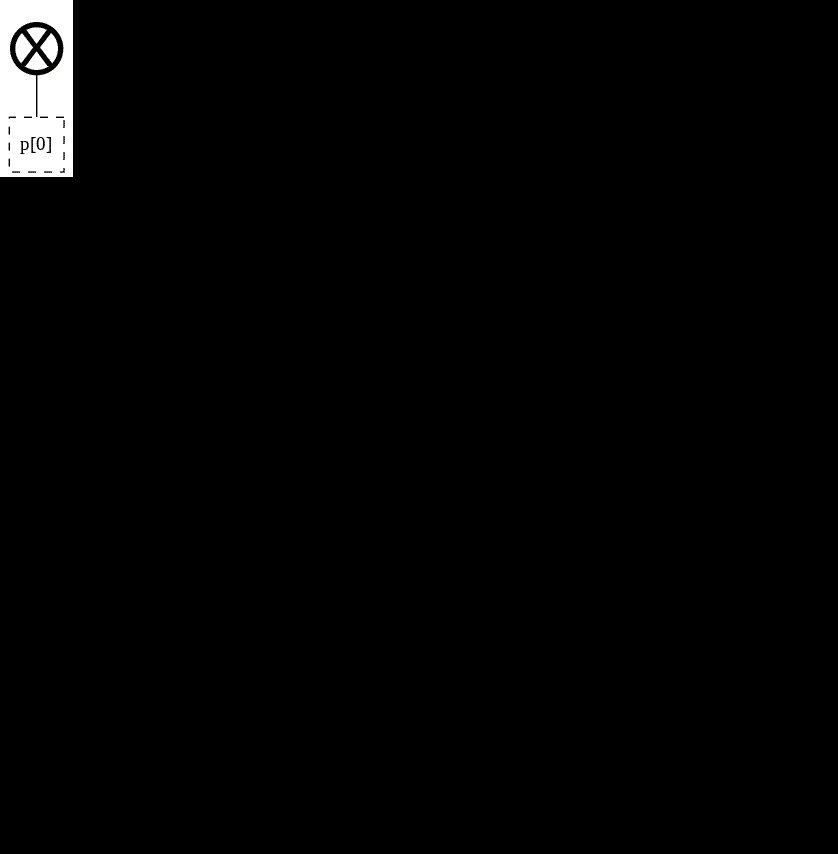

In [ ]:
# Serial structure
f = forest(9)
f

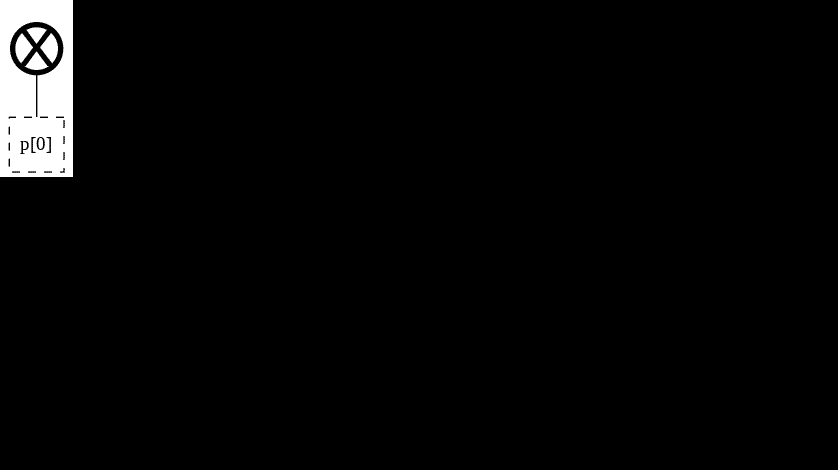

In [ ]:
# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
f

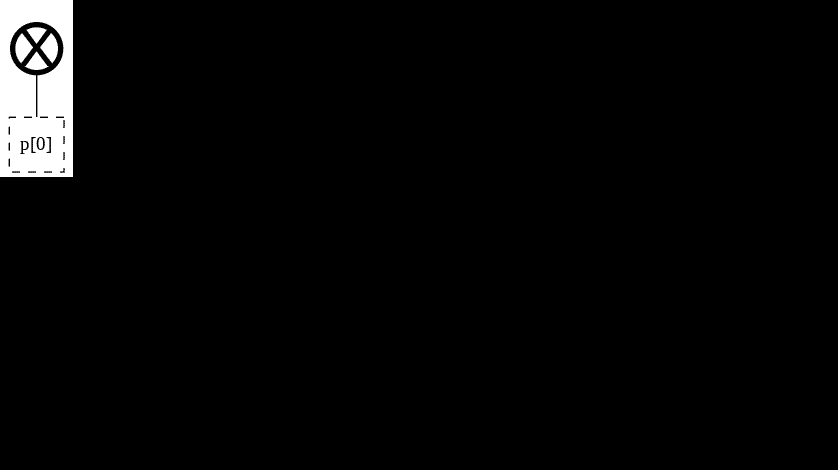

In [ ]:
# Kogge-Stone structure
f = forest(9)
for t in f.trees[2:]:
  t.lbalance(t.root[1])
  t.equalize_depths(t.root[1])
f

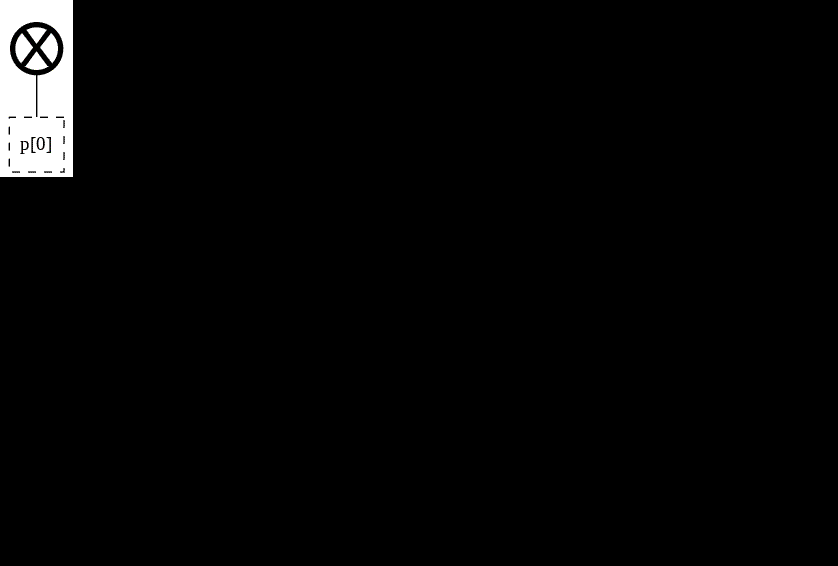

In [ ]:
# Brent-Kung structure, before the fan-out is decoupled
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
  # Same as Sklansky so far
  while not t.root[1][0].is_proper():
    t.right_rotate(t.root[1][0])
f

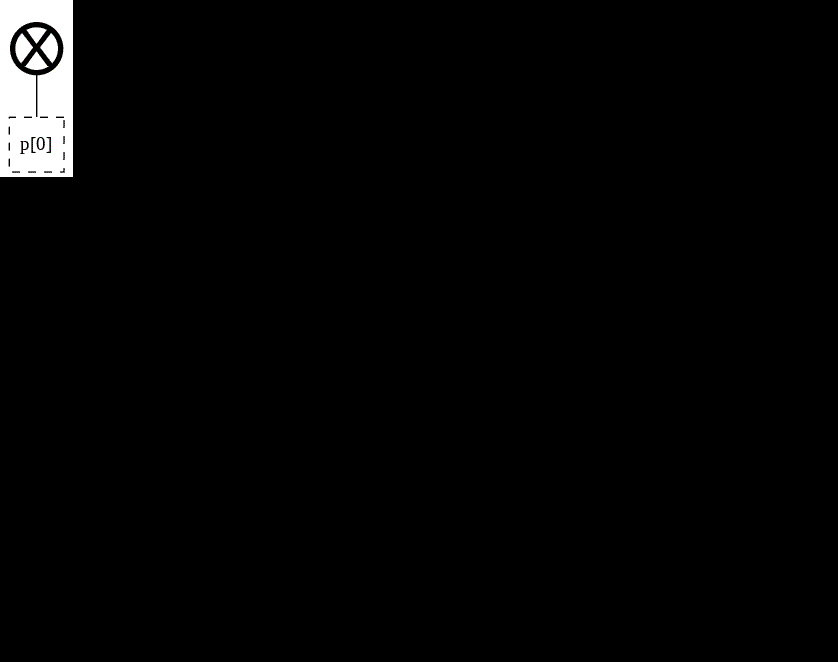

In [ ]:
# And now Brent-Kung with the fan-out decoupled
# Note that this relies on the previous cell having been run
f.calculate_fanout()
f.decouple_all_fanout(2)
f

These all generate the same hardware as the structures in the previous section.

![](https://drive.google.com/uc?export=view&id=1Gv0lAGly1fQeGrEbLMuwlNQkttaHoO7s)

### Post-classic structures

Here are some examples of structures that are impossible to depict under the old system.

First, it is now known exactly how many possible structures there are (at least before the next two sections expand further).

Different ways of decoupling fan-out are intentionally ignored for reasons that this margin is too small to contain.

In [ ]:
width = 9
number_of_structures = 1
for a in range(2,width):
  number_of_structures = number_of_structures * catalan(a-2)
print(number_of_structures)

776160


Here is one arbitrary previously-impossible structure.<br>
There are many such examples, and the next two sections will introduce even more useful ones.

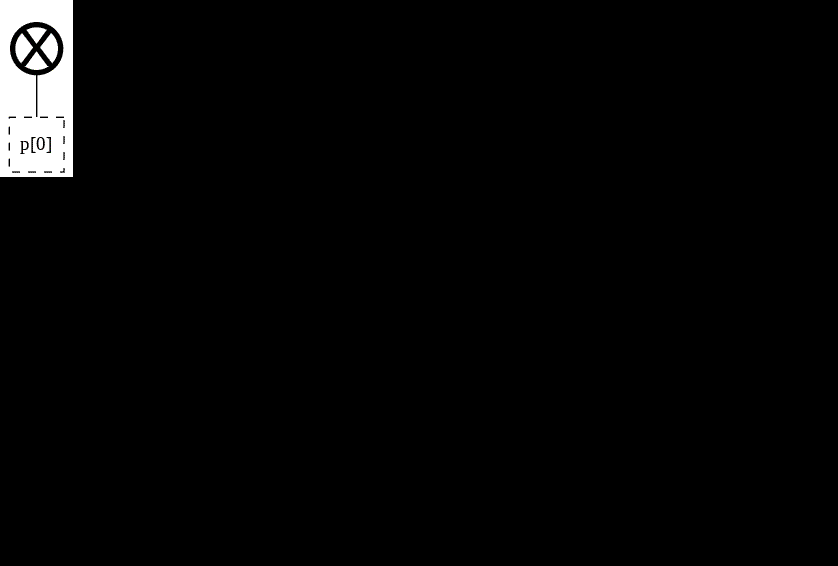

In [ ]:
f = forest(9, tree_start_points = [0, 0, 0, 1, 4, 12, 21, 47, 217])
f

## Adder-specific optimizations [Part I - Sparseness]

### Setup (RUN ME before executing any code in this section)

If the cell below prints a warning in red telling you to "restart runtime", please do so using the provided button.

This section uses the current version of the codebase.

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git to /tmp/pip-req-build-rfeopu6m
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-rfeopu6m


In [ ]:
from pptrees.AdderTree import AdderTree as tree
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan

### Doesn't everything discussed so far apply to any operation, not just binary addition?

Yes. It does.

Here are a couple of things that are less general, but still apply to a large variety of operations, including binary addition.

### Integrating the post-processing logic into the tree

As previously mentioned, binary addition consists of a local and a non-local aspect.<br>
Post-processing logic is used to combine these into a final answer.

Can this post-processing also associate?

Yes! This is a concept well-known as sparsenesss. The normal form of the post-processing logic gate is the XOR seen below, while its associative form is the MUX seen below. Note that the two cells have nearly identical footprints, which is to say, swapping the non-associative XOR for an associative MUX can be done at little cost.

![](https://drive.google.com/uc?export=view&id=1Gv0lAGly1fQeGrEbLMuwlNQkttaHoO7s)

### Regular sparseness

Here is an example of a classic structure with regularly-applied sparseness of degree 1.

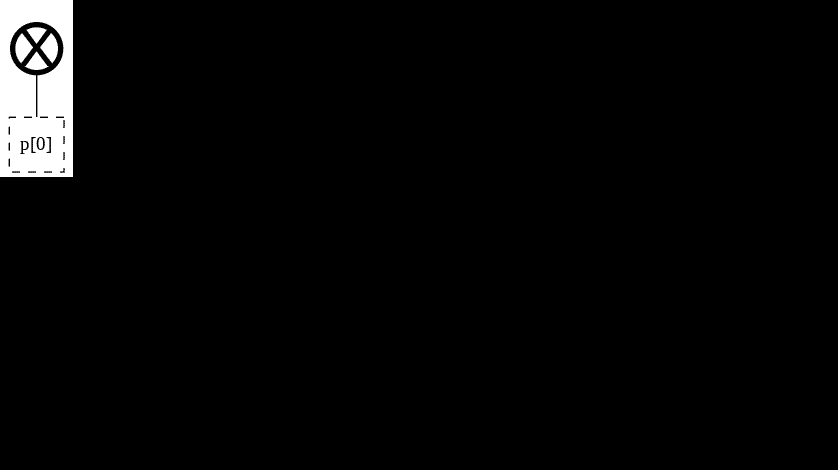

In [ ]:
# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply regular sparseness of degree 1
for a in range(len(f.trees[2:])):
  # Skip the first two trees, of widths 0 and 1
  t = f[a+2]
  # Apply sparseness every 2 trees
  if (a % 2 == 1):
    # Apply only 1 degree of sparseness
    t.left_shift(t.root[1].leftmost_leaf().parent)
f

Every other tree shifts exactly 1 node onto the left side of the tree.

Watch the GIF carefully. Notice that each frame with sparseness applied to it makes use of the same logic as the previous frame.

This saves a large amount of area and power consumption, as the same sub-trees can be re-used.

### Regular sparseness of higher degree

Here is an example of a classic structure with regularly-applied sparseness of degree 3, such as in Naffziger's adder or Lynch-Swartzlander's spanning-tree adder.

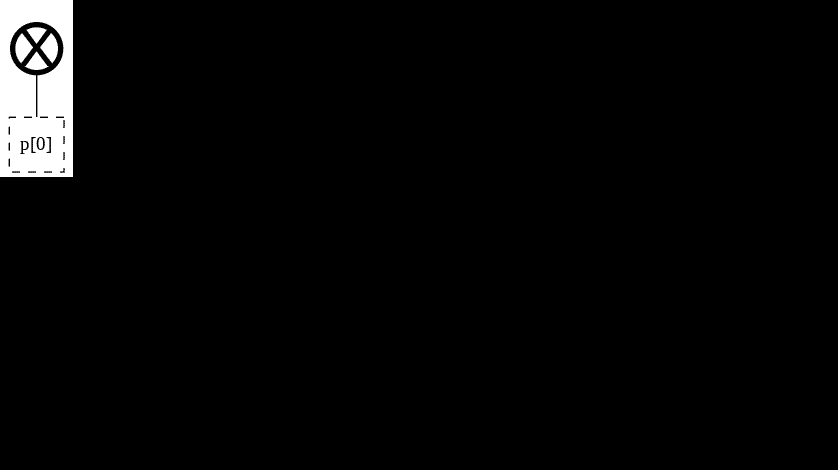

In [ ]:
# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply regular sparseness of degree 3
for a in range(len(f.trees[4:])):
  # Skip the first 4 trees, of widths 0, 1, 2, 3
  t = f[a+4]
  # Apply sparseness every 4 trees
  if (a % 4 != 0):
    # Apply multiple degrees of sparseness
    t.left_rotate(t.root[1])
f

Every fourth tree shifts $i\%4$ trees onto the left side of the tree.

Watch the GIF carefully. Note the 4 consecutive frames that all share the same right half of the tree. Again, this can save a large amount of area and power consumption.

### Irregular sparseness

If sparseness can save a lot of area and power consumption by knocking out a whole section of the tree, would it not make sense to apply sparseness more aggressively on bigger trees?

That is to say, instead of applying sparseness every 2 or every 4 nodes, why not apply sparseness of degree 8 on trees 54 through 64, sparseness of degree 6 on trees 40 through 54, sparseness of degree 5 on tree 39 just for fun, sparseness of degree 4 on trees 20 through 39, etecetera.

It certainly sounds like this would be superior to regular applications of sparseness. Yet there are almost no examples of this method in literature.

Why? It is ridiculously hard to do by hand.

Luckily, I've made a tool that can do it.

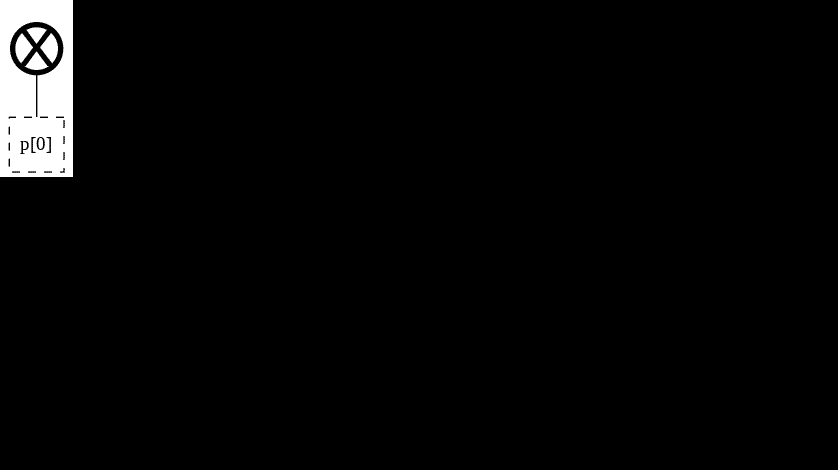

In [ ]:
# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply arbitrary amounts of sparseness, for illustrative purposes
## One shift on tree 2
f[2].left_shift(f[2].root[1].leftmost_leaf().parent)
## Two shifts on tree 4
f[4].left_rotate(f[4].root[1])
## Three shifts on tree 8
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
## Avoid spoiling the next sub-section
f[8].right_rotate(f[8].root[0][0])
f[8].right_rotate(f[8].root[0][0])
f

### Nested sparseness

Viewing sparseness through the lens of this new style of adder diagrams raises an interesting question.

If sparseness is just the action of shifting some nodes onto the left side of the tree.

Can they not be shifted even further left, in a sort of "nested" sparseness?

Indeed they can, which leads to novel structures not previously seen in literature.

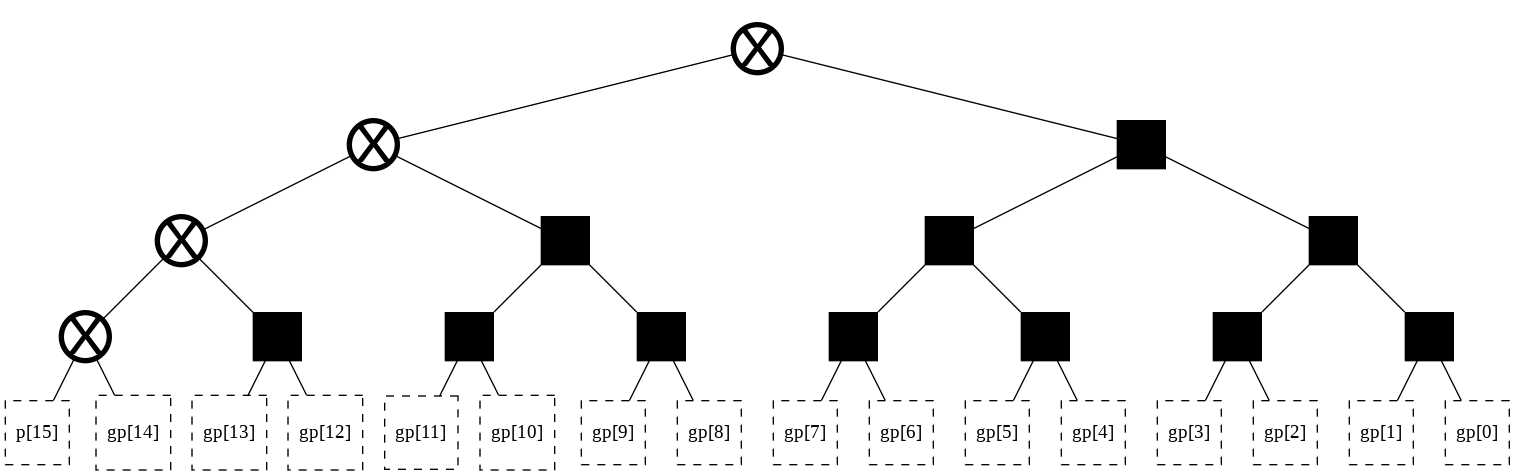

In [ ]:
# Fully-balanced tree
t = tree(16)
t.balance(t.root)
t

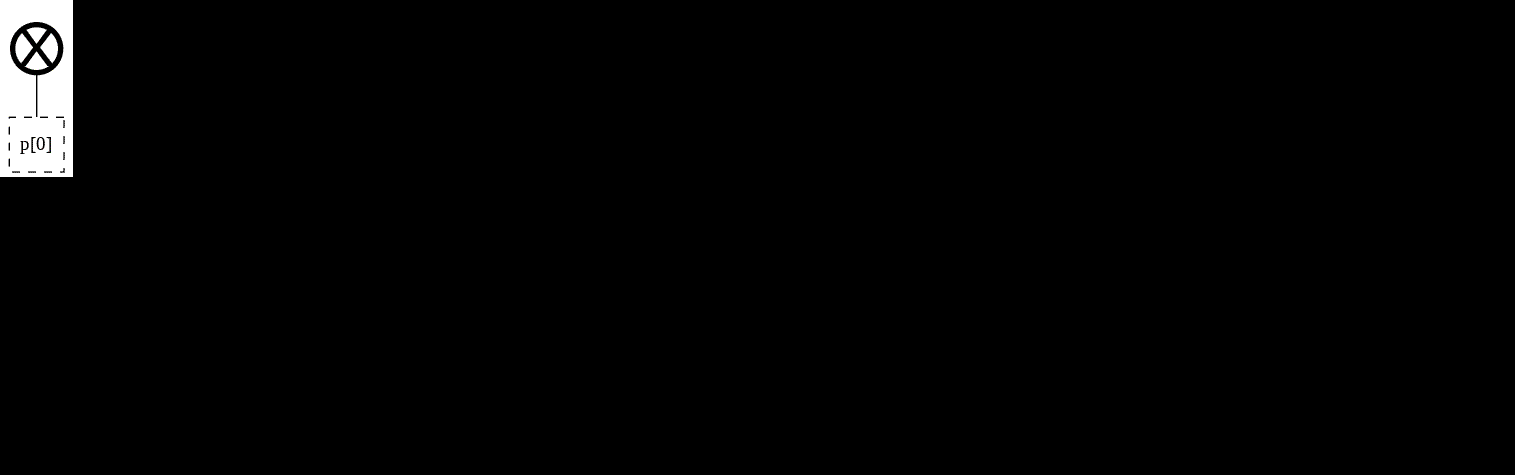

In [ ]:
# Fully-balanced forest
f = forest(16)
for t in f.trees[2:]:
  t.rbalance(t.root)
f

### Adder-specific?

Note that this optimization is not adder-specific, but instead can be applied to any operation whose local component similarly involves a multi-plexer or some other cell with a similar footprint.

A simple example is a leading-zero detection circuit that feeds into a shifter. The shifter acts as the local component, allowing it to be integrated into the tree in similar fashion as with addition's post-processing node.

## Adder-specific optimizations [Part II - Factorization]

**NOTE**: This is a work in progress and will not be functional until version **1.1.0** of the library

### Setup (RUN ME before executing any code in this section)

If the cell below prints a warning in red telling you to "restart runtime", please do so using the provided button.

This section uses the current version of the codebase.

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git to /tmp/pip-req-build-4pvpenzv
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-4pvpenzv
  Created wheel for pptrees: filename=pptrees-1.0.5-py3-none-any.whl size=62245 sha256=c042ce21a9183dcaa1826ec41c68cff6d0bba214e2d59ed9d85a27ed0dec851e
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2yzrpv7/wheels/46/ba/74/bbe32b722a1f52c3c3aa52fcbdb050975cb54826ed0e4f77cd
Successfully built pptrees


In [ ]:
from pptrees.AdderTree import AdderTree as tree
from pptrees.AdderForest import AdderForest as forest

### Integrating the pre-processing logic into the tree

The circuits shown so far consist of three parts:

*   "pre-processing" logic, which encodes the inputs into an alternate form
*   The main body of the tree, which computes the non-local aspect of the operation
*   "post-processing" logic, which combines the non-local and local aspects of the operation

The previous section shows a novel way of integrating the post-processing logic into the main body of the tree.

Is there a way to integrate the pre-processing logic into the main body of the tree?

In a way, yes, there is.

### Ling factorization

An earlier section showed the following CMOS schematic of the ■ recurrence operator for addition:

![](https://drive.google.com/uc?export=view&id=1O0v4RCn8GlN10Adtne98e0Ir0CU-Goqg)

The section on the right is a two-input gate.<br>
The section on the left is a three-input gate.<br>

One of the inputs to that three-input gate can be factored off onto a parallel path.<br>
Below are results of a spice simulation showing the effect this has on delay.

![](https://drive.google.com/uc?export=view&id=1eTOBLmIOjD29-lLU9F1AemXIKTRNoeFq)

Note however that moving logic onto a parallel path leads to increased area and power consumption, and vastly increased complexity which can ultimately eliminate the benefits of the delay reduction.

### What is the Ling factorization expressed in terms of trees?

This factorization can be seen as a stereoscopic composition of trees.

Just like with 3D glasses, there is a red lens and a blue lens, and the images they create combine into the overall picture.

Here is the blue lens:

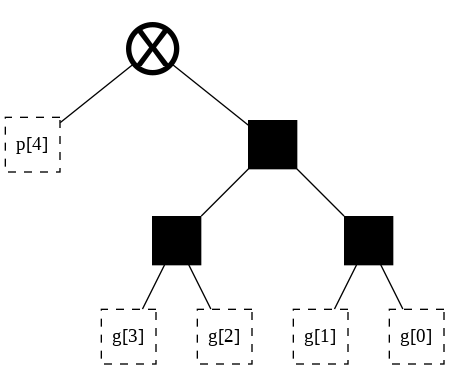

In [ ]:
t = tree(5, start_point = 2, leaf_labels = ["c","g","p"])
t

Here is one possible red lens:

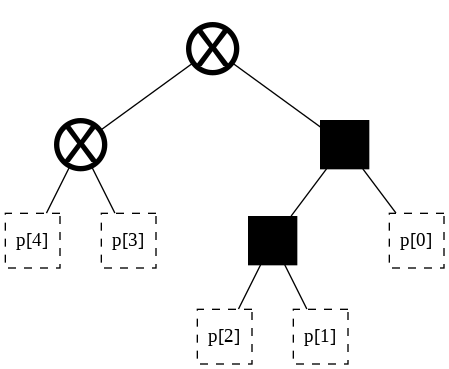

In [ ]:
t = tree(5, start_point = 6, leaf_labels = ["c","p","p"])
t

These two trees can be overlaid on top of each other, like transparencies on a projector screen.

Their stereoscopic composition then gives rise to a new structure.

### Arbitrary combination of Ling and sparseness

The framework described thus far allows for arbitrary combinations of Ling and sparseness, whereas prior work only applies them in simple, regular, fashion.

Such logic would be incredibly difficult to design by hand.<br>
Luckily, a tool exists that can automatically do it.

### Adder-specific?

Note that this optimization is not adder-specific, but instead can be applied to any operation where a similar factorization can be performed.

A simple example is a leading-zero detection circuit.

# Forests [structures that generate the entire result]

## Setup (RUN ME before executing any code in this section)

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git@v1.0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git (to revision v1.0.5) to /tmp/pip-req-build-b6dtl5ix
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-b6dtl5ix
  Running command git checkout -q cbf5e7e8d9b501bb501fefdd463f1ff3b9644a60
  Created wheel for pptrees: filename=pptrees-1.0.5-py3-none-any.whl size=61676 sha256=70d579f4abaf34513e5953ff6619bd02d973061273e993cccbc1defe6825c4b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-yb5o7368/wheels/c6/3a/84/a6f13e63cee175e7643641f543504123889d15ad88285c95db
Successfully built pptrees


## Generating a classic structure [LEGACY]

Note: these cells are shown simply for illustrative purposes.<br>
The functionality in this section is legacy, supported only for backwards compatibility with past diagrams and methods.<br>
The code in this section should not be used in production.

The theory section discusses four classic, regular, structures.<br>
These architectures can be readily generated under this library using aliases.<br>
Note again that the "alias" parameter is legacy, supported only for backwards compatibility, and should not actually be used.

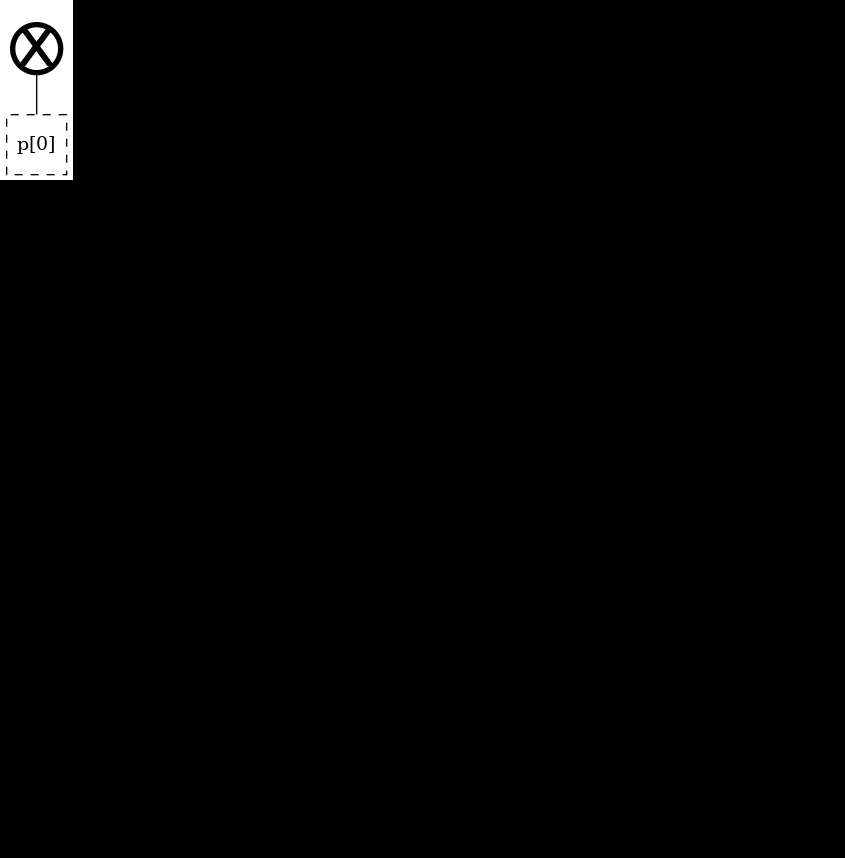

In [1]:
from pptrees.AdderForest import AdderForest as forest

width = 9
f = forest(width, alias = "ripple-carry")
f

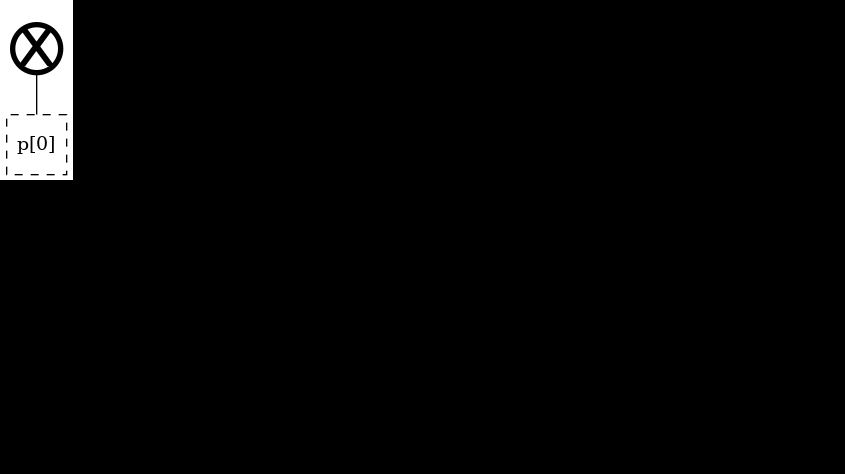

In [2]:
from pptrees.AdderTree import AdderTree as tree

width = 9
f = forest(width, alias = "sklansky")
f

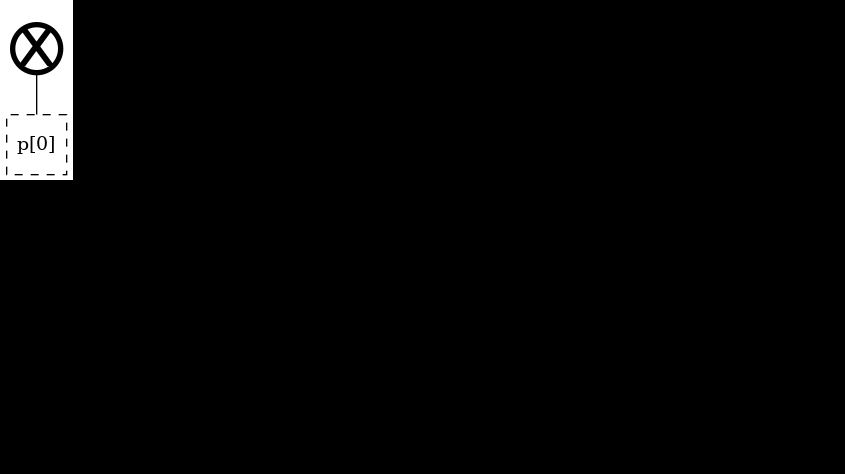

In [3]:
from pptrees.AdderTree import AdderTree as tree

width = 9
f = forest(width, alias = "kogge-stone")
f

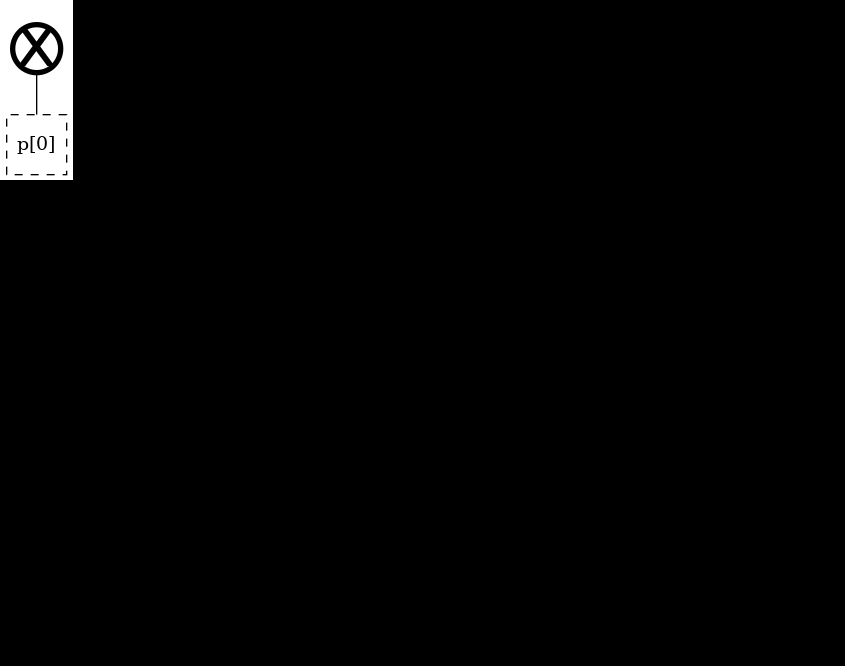

In [5]:
from pptrees.AdderTree import AdderTree as tree

width = 9
f = forest(width, alias = "brent-kung")
f.unmark_equivalent_nodes()
f

## How many possible forests are there?

In [6]:
from pptrees.util import catalan

width = 9
number_of_forests = 1
for a in range(width):
  number_of_forests = number_of_forests * catalan(a)
print(number_of_forests)

476150875200


## What do these forests look like?

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


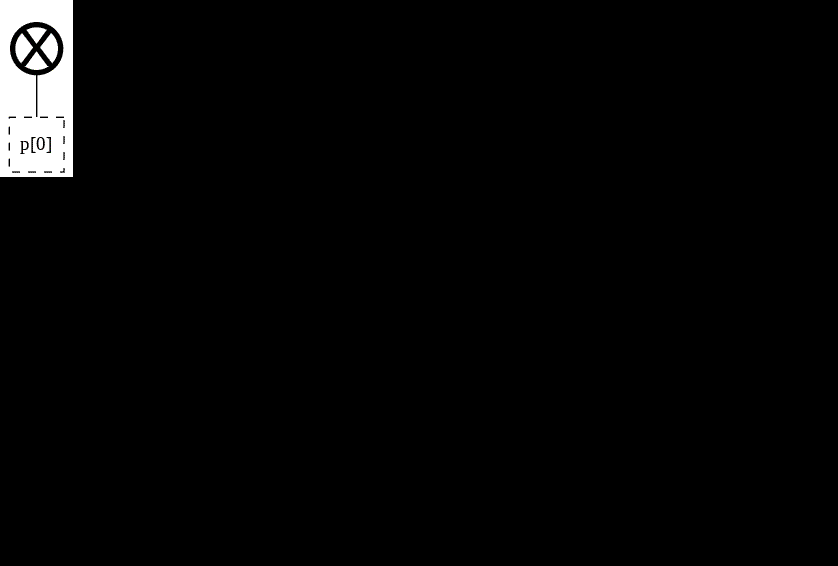

In [ ]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
f

## How do I get the forest that I want?

There are two, equivalent, ways to initialize a forest:

1.   Obtain a list of tree IDs, and use them to initialize the forest
2.   Obtain a list of trees, and use them to initialize the forest



The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


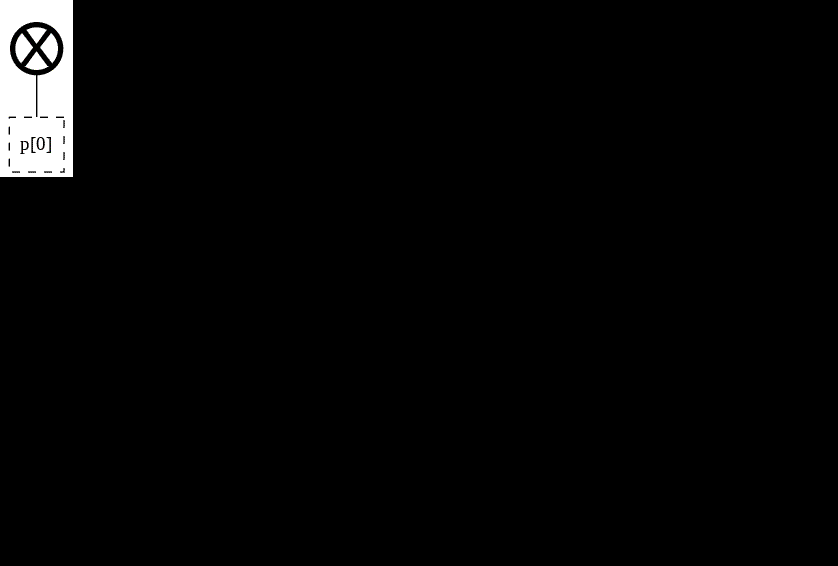

In [ ]:
# Method 1
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
f

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


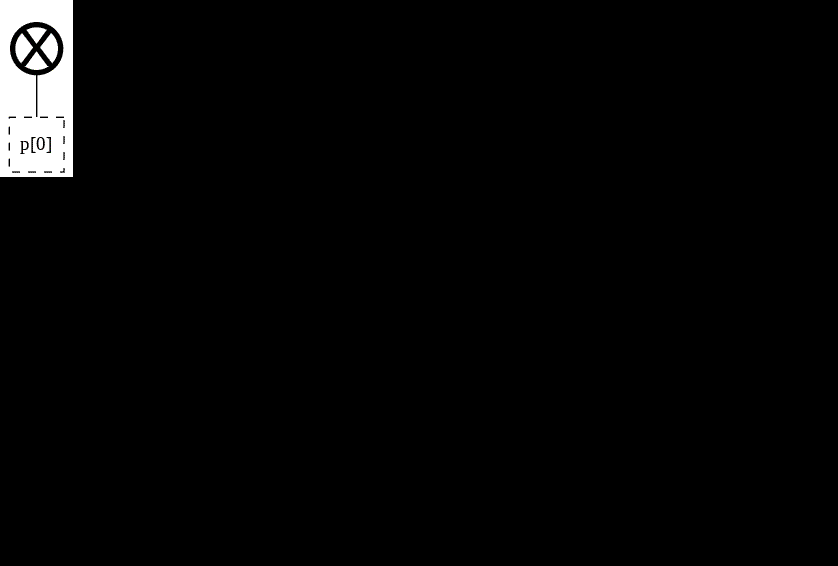

In [ ]:
# Method 2
from pptrees.AdderForest import AdderForest as forest
from pptrees.AdderTree import AdderTree as tree
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))

list_of_trees = []
list_of_trees.append(tree(1, start_point = 0))
list_of_trees.append(tree(2, start_point = 0))
list_of_trees.append(tree(3, start_point = 0))
list_of_trees.append(tree(4, start_point = 2))
list_of_trees.append(tree(5, start_point = 5))
list_of_trees.append(tree(6, start_point = 37))
list_of_trees.append(tree(7, start_point = 74))
list_of_trees.append(tree(8, start_point = 214))
list_of_trees.append(tree(9, start_point = 214))

f = forest(width, initialized_trees = list_of_trees)
f

## Okay, I have a forest. How do I make it faster?

In short, this can be achieved by making the underlying trees faster.

There is no hard rule for how this can be achieved. In general, here are some tips:

*   Reducing logic levels increases speed (at the cost of fanout and tracks)
*   Reducing fanout increases speed (at the cost of logic levels and tracks)
*   Reducing tracks increases speed (at the cost of logic levels and fanout)

Typically these three parameters affect delay in the order in which they are listed above, though that is not always the case.



Let's look at the previous forest example.

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


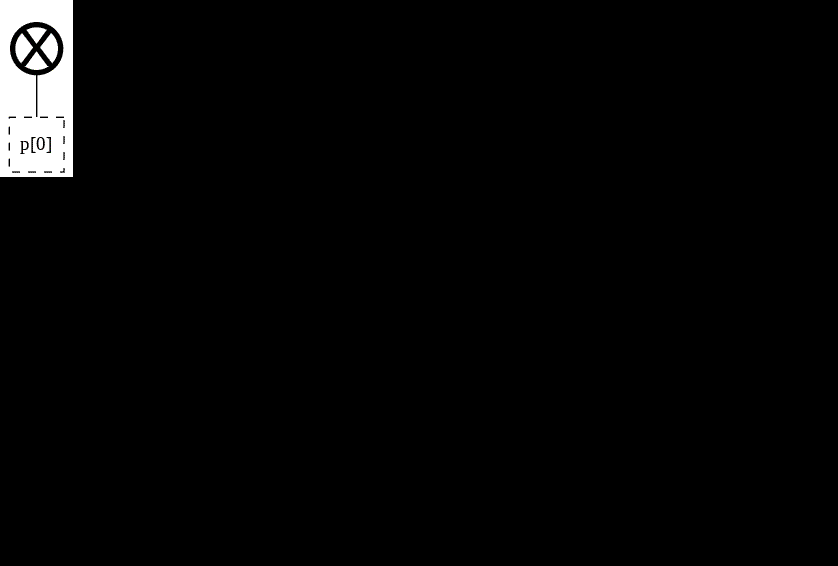

In [ ]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
f

Tree 5 (the 6th frame) is very unbalanced. Let's take a closer look.

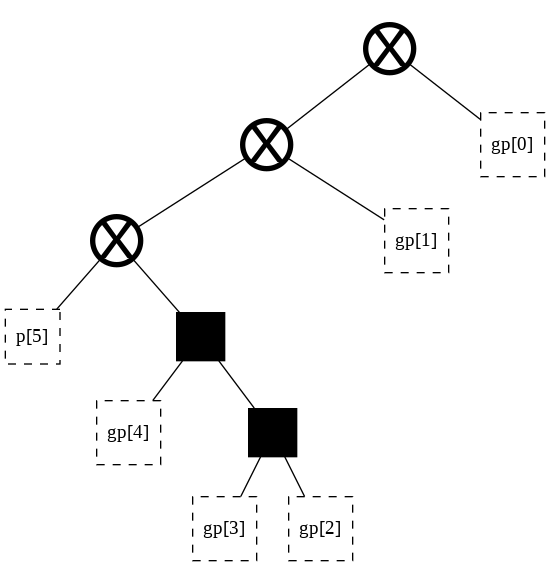

In [ ]:
f[5]

Let's reduce its height.

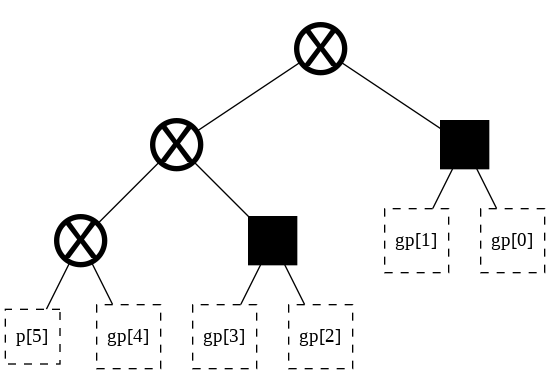

In [ ]:
f[5].left_rotate(f[5].root[0][0][1])
f[5].right_rotate(f[5].root[0][0])
f[5].right_shift(f[5].root[0][1])
f[5]

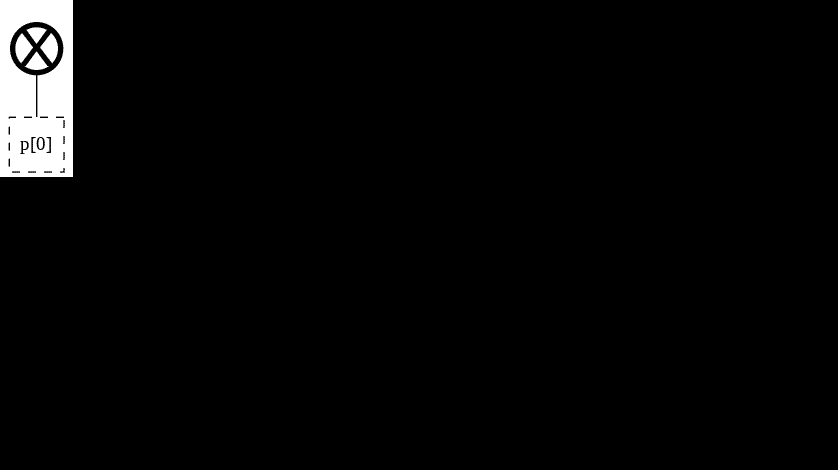

In [ ]:
f

## Okay, now how do I make a forest more power-efficient? Or smaller?

This can be achieved by making the individual trees in the forest share more nodes.

In general, the further to the left a node is, the more likely it is to be shared. Nodes on the right spine can never be shared.

Let's look at the previous forest example.

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


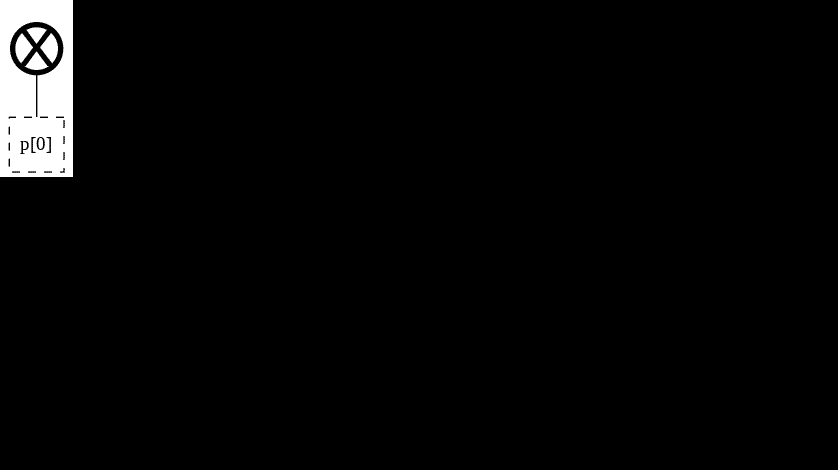

In [ ]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
f[5].left_rotate(f[5].root[0][0][1])
f[5].right_rotate(f[5].root[0][0])
f[5].right_shift(f[5].root[0][1])
f.find_equivalent_nodes()
f

Tne nodes that have been painted partially red are duplicates that need not be implemented in hardware. In other words, they are redundant copies of shared nodes.
This is merely cosmetic, intended to serve as a visual indicator.

Note that the very last frame of the shot has no such red-marked nods. Shared nodes only need to be implemented in hardware once, but they still need to be implemented that one time.

Most of the normal recurrence nodes used in the forest are already shared.<br>
However, the nodes on the left spine can never be shared.<br>
The left spine represents the combination of local and non-local aspects of the operation of binary addition. Each tree has its own unique local aspect.

Thus, one effective way to reduce the area and power consumption of the design is to move nodes off of the left spine.

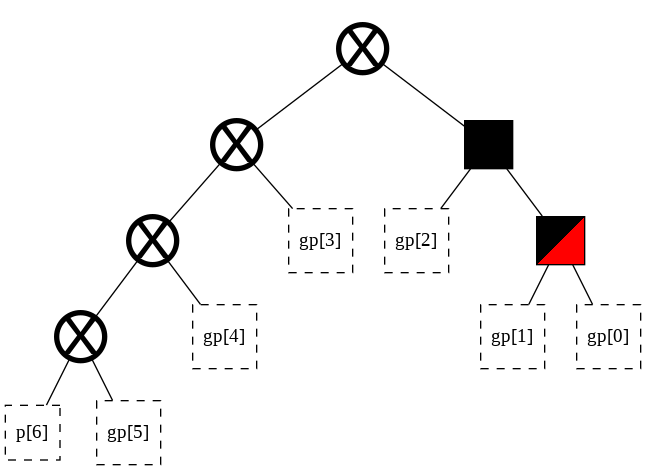

In [ ]:
f[6]

This seems as good of a candidate for rotation as any.

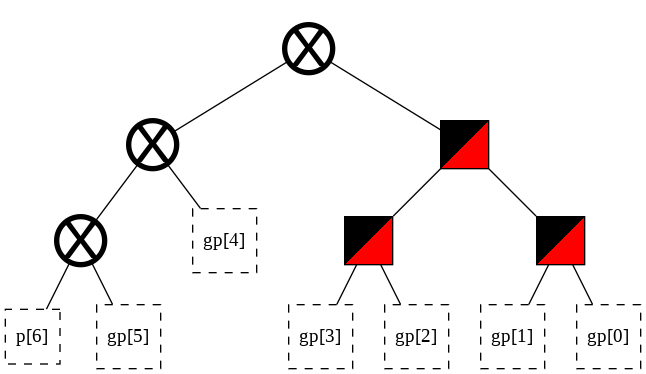

In [ ]:
f.reset_equivalent_nodes()
f[6].right_rotate(f[6].root[0])
f[6].left_rotate(f[6].root[1][1])
f.find_equivalent_nodes()
f[6]

Success! Area has been reduced by two nodes, which in this adder represents about a 6% improvement in area, and likely in power consumption as well.

Unfortunately, this modification has increased the fanout on the critical path, slowing down the maximum achievable speed of the design.

## What about fan-out decoupling / buffer insertion?

Fan-out decoupling, or buffer insertion, is a very important concept in hardware design. If a cell is driving 16 outputs, it could instead be made to drive 4 buffers, each of which drive 4 outputs of their own. Reducing fanout intelligently can improve the speed of a design, even while adding cells onto the circuit's timing paths.

Buffer insertion, or fanout decoupling, is not an inherent feature of logically synthesized hardware. It is a layout optimization to be performed after logical synthesis.

### But wait! Buffer insertion is the whole point of important classic structures such as Brent-Kung!

This is a Brent-Kung adder without buffer insertion:

The maximum tree sizes for a forest of width 17 are [0, 0, 1, 4, 13, 41, 131, 428, 1429, 4861, 16795, 58785, 208011, 742899, 2674439, 9694844, 35357669]


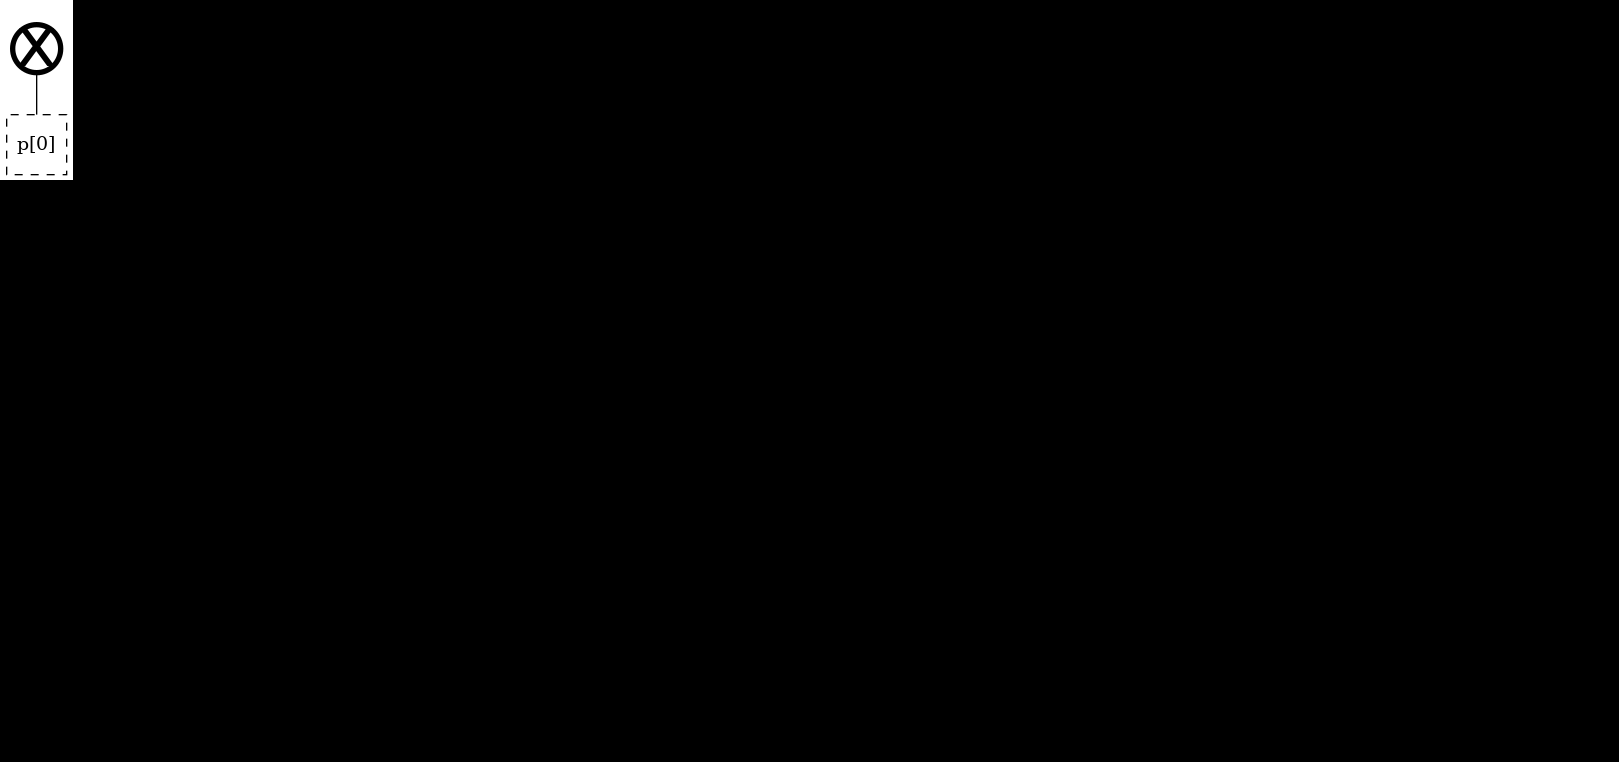

In [7]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 17
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
  while not t.root[1][0].is_proper():
    t.right_rotate(t.root[1][0])
f.find_equivalent_nodes()
f

This is a Brent-Kung adder with buffer insertion:

The maximum tree sizes for a forest of width 17 are [0, 0, 1, 4, 13, 41, 131, 428, 1429, 4861, 16795, 58785, 208011, 742899, 2674439, 9694844, 35357669]


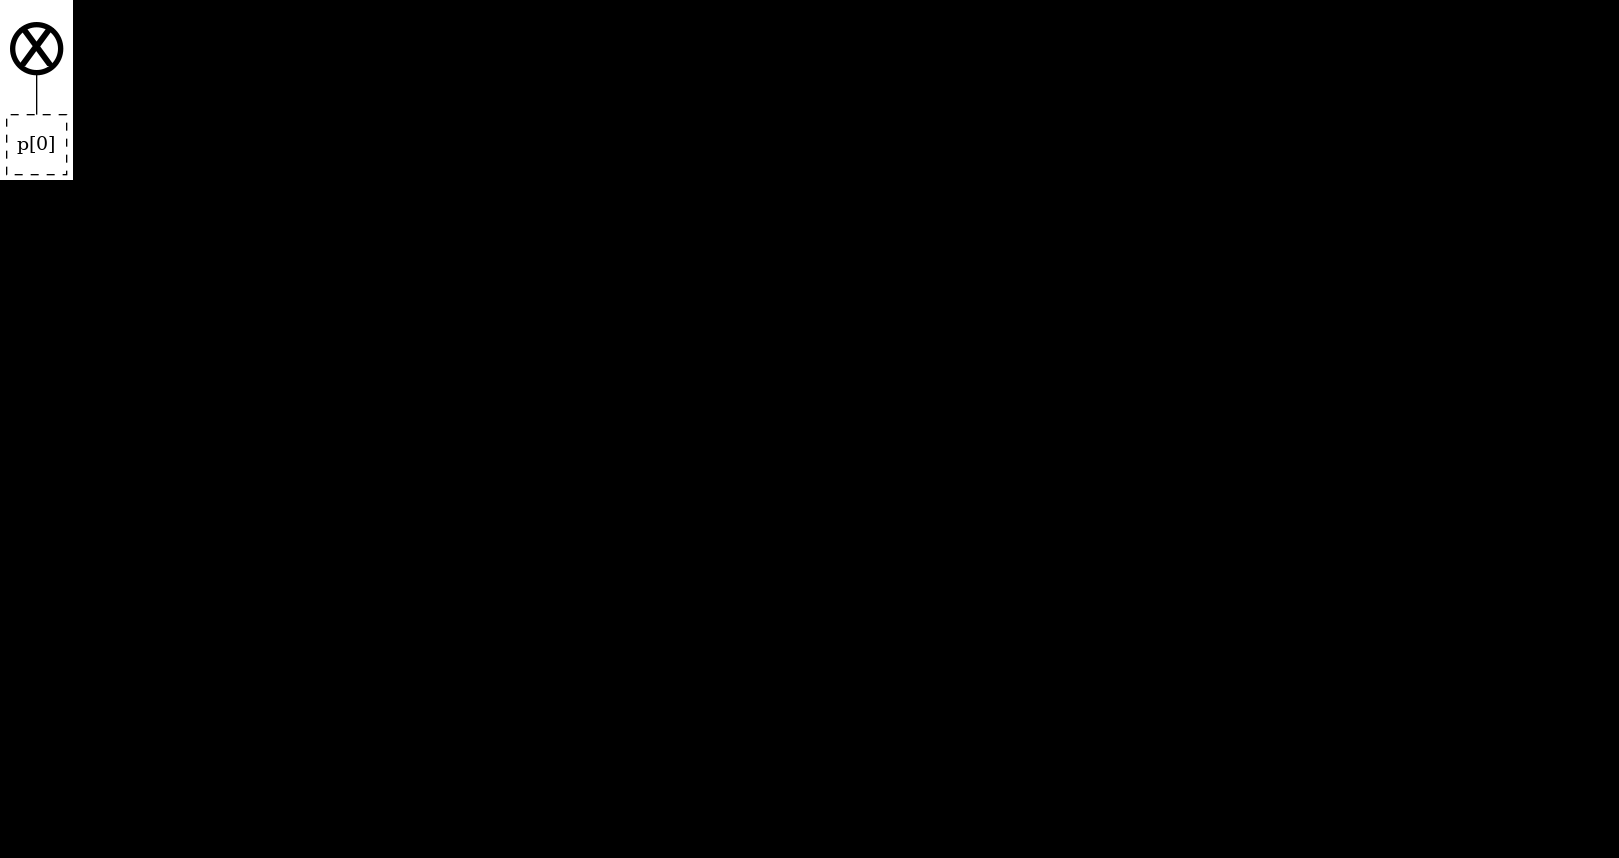

In [8]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 17
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
  while not t.root[1][0].is_proper():
    t.right_rotate(t.root[1][0])
f.find_equivalent_nodes()
f.calculate_fanout()
f.calculate_tracks()
f.decouple_all_fanout(maximum_fanout = 2)
f

The buffers are not the core benefit of Brent-Kung. The shared nodes are.<br>
Despite much personal misgiving, I have decided to accept the fact that buffer insertion is a post-production step, not an integral part of the tree structure.<br>
This point can be argued for a long time, but this is not the platform.

### Buffer insertion using this library

Buffer insertion can be readily performed through the insert_buffer and remove_buffer methods.

Let's look at the previous example.

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]


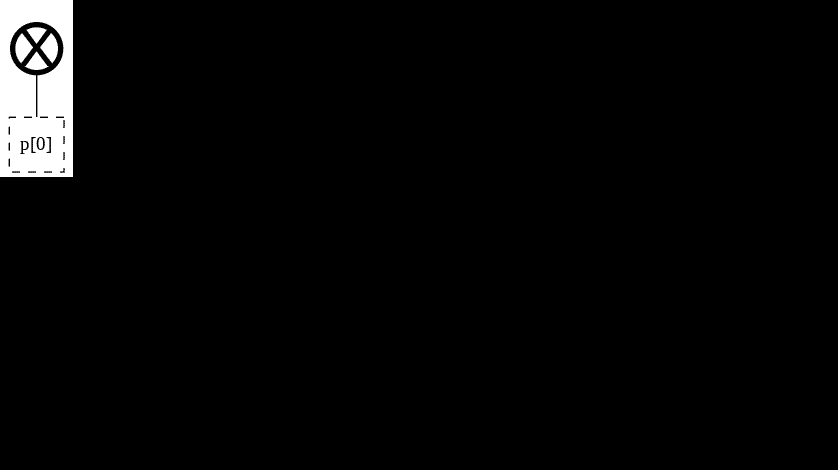

In [ ]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
f[5].left_rotate(f[5].root[0][0][1])
f[5].right_rotate(f[5].root[0][0])
f[5].right_shift(f[5].root[0][1])
f[6].right_rotate(f[6].root[0])
f[6].left_rotate(f[6].root[1][1])
f

There is clearly a lot of fanout on the node that combines gp[1] with gp[0].<br>
Let us reduce it through buffer insertion.

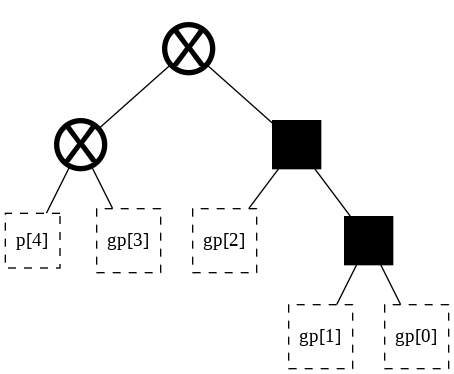

In [ ]:
f[4]

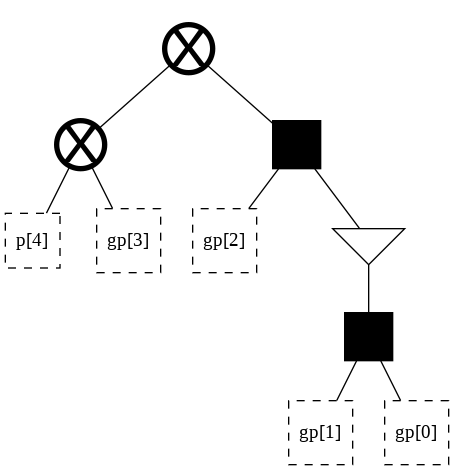

In [ ]:
f[4].insert_buffer(f[4].root[1][1])
f[4]

A convenient short-hand is also provided in the form of the decouple_fanout method. This method takes as argument a node whose output has fanout, and a tree chosen as a sacrifice. It then decouples the node's fanout by inserting a buffer into the chosen ~~tribute~~ tree.

This does require that the calculate_fanout method be executed first.

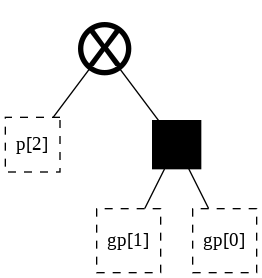

In [ ]:
f[2]

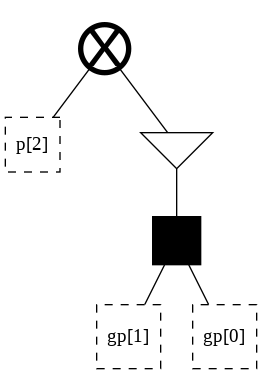

In [ ]:
f.calculate_fanout()
f.unmark_equivalent_nodes()
f.decouple_fanout(f[8].root[1][1][1],f[2])
f[2]

### Obtaining an HDL description

A basic HDL file can be obtained very simply, using the hdl()

In [2]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
_ = f.hdl("adder1.v", module_name="adder1")

!cat adder1.v

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]

module adder1(

	input [8:0] a_in,
	input [8:0] b_in,
	output [8:0] sum
	);


	adder1_tree_8 U0(
		.a_in(a_in[8:0]),
		.b_in(b_in[8:0]),
		.sum(sum[8])
	);

	adder1_tree_7 U1(
		.a_in(a_in[7:0]),
		.b_in(b_in[7:0]),
		.sum(sum[7])
	);

	adder1_tree_6 U2(
		.a_in(a_in[6:0]),
		.b_in(b_in[6:0]),
		.sum(sum[6])
	);

	adder1_tree_5 U3(
		.a_in(a_in[5:0]),
		.b_in(b_in[5:0]),
		.sum(sum[5])
	);

	adder1_tree_4 U4(
		.a_in(a_in[4:0]),
		.b_in(b_in[4:0]),
		.sum(sum[4])
	);

	adder1_tree_3 U5(
		.a_in(a_in[3:0]),
		.b_in(b_in[3:0]),
		.sum(sum[3])
	);

	adder1_tree_2 U6(
		.a_in(a_in[2:0]),
		.b_in(b_in[2:0]),
		.sum(sum[2])
	);

	adder1_tree_1 U7(
		.a_in(a_in[1:0]),
		.b_in(b_in[1:0]),
		.sum(sum[1])
	);

	adder1_tree_0 U8(
		.a_in(a_in[0]),
		.b_in(b_in[0]),
		.sum(sum[0])
	);
endmodule // adder1

module adder1_tree_0(

	input  a_in,
	input  b_in,
	output  sum
	);

// adder_forest tree_0
	wire n1_tree_

By default, HDL is behavioral.<br>
However, it can be very readily mapped onto a supported technology.<br>
This instantiates the required standard cell, resulting in structural HDL that is ready to be used by a place-and-route tool.

In [3]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
_ = f.hdl('mapped.v', optimization = 0, mapping = "sky130_fd_sc_hd")

!cat mapped.v

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]

module adder(

	input [8:0] a_in,
	input [8:0] b_in,
	output [8:0] sum
	);


	adder_tree_8 U0(
		.a_in(a_in[8:0]),
		.b_in(b_in[8:0]),
		.sum(sum[8])
	);

	adder_tree_7 U1(
		.a_in(a_in[7:0]),
		.b_in(b_in[7:0]),
		.sum(sum[7])
	);

	adder_tree_6 U2(
		.a_in(a_in[6:0]),
		.b_in(b_in[6:0]),
		.sum(sum[6])
	);

	adder_tree_5 U3(
		.a_in(a_in[5:0]),
		.b_in(b_in[5:0]),
		.sum(sum[5])
	);

	adder_tree_4 U4(
		.a_in(a_in[4:0]),
		.b_in(b_in[4:0]),
		.sum(sum[4])
	);

	adder_tree_3 U5(
		.a_in(a_in[3:0]),
		.b_in(b_in[3:0]),
		.sum(sum[3])
	);

	adder_tree_2 U6(
		.a_in(a_in[2:0]),
		.b_in(b_in[2:0]),
		.sum(sum[2])
	);

	adder_tree_1 U7(
		.a_in(a_in[1:0]),
		.b_in(b_in[1:0]),
		.sum(sum[1])
	);

	adder_tree_0 U8(
		.a_in(a_in[0]),
		.b_in(b_in[0]),
		.sum(sum[0])
	);
endmodule // adder

module adder_tree_0(

	input  a_in,
	input  b_in,
	output  sum
	);

// adder_forest tree_0
	wire n1_tree_0;
	assign s

However, synthesis tools do play another important role: they perform optimizations.

This library contains three levels of pre-optimization that is done to assist synthesis tools.

Level 0 of optimization is unoptimized.

Level 1 of optimization performs operation-specific logic trimming.

Certain operations, such as binary addition, allow for the simplification of logic on locations such as the most-significant or least-significant bit. This library can perform such optimizations.<br>
This is the recommended setting.

In [4]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
_ = f.hdl('mapped_opt1.v', optimization = 1, mapping = "sky130_fd_sc_hd")

!cat mapped_opt1.v

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]

module adder(

	input [8:0] a_in,
	input [8:0] b_in,
	output [8:0] sum
	);


	adder_tree_8 U0(
		.a_in(a_in[8:0]),
		.b_in(b_in[8:0]),
		.sum(sum[8])
	);

	adder_tree_7 U1(
		.a_in(a_in[7:0]),
		.b_in(b_in[7:0]),
		.sum(sum[7])
	);

	adder_tree_6 U2(
		.a_in(a_in[6:0]),
		.b_in(b_in[6:0]),
		.sum(sum[6])
	);

	adder_tree_5 U3(
		.a_in(a_in[5:0]),
		.b_in(b_in[5:0]),
		.sum(sum[5])
	);

	adder_tree_4 U4(
		.a_in(a_in[4:0]),
		.b_in(b_in[4:0]),
		.sum(sum[4])
	);

	adder_tree_3 U5(
		.a_in(a_in[3:0]),
		.b_in(b_in[3:0]),
		.sum(sum[3])
	);

	adder_tree_2 U6(
		.a_in(a_in[2:0]),
		.b_in(b_in[2:0]),
		.sum(sum[2])
	);

	adder_tree_1 U7(
		.a_in(a_in[1:0]),
		.b_in(b_in[1:0]),
		.sum(sum[1])
	);

	adder_tree_0 U8(
		.a_in(a_in[0]),
		.b_in(b_in[0]),
		.sum(sum[0])
	);
endmodule // adder

module adder_tree_0(

	input  a_in,
	input  b_in,
	output  sum
	);

// adder_forest tree_0
	wire n1_tree_0;
	assign s

Level 2 of optimization partitions the design into separate, flattened, sub-blocks.

Both proprietary as well as open-source tools heavily struggle with the optimization of fully-flattened arithmetic circuits, such as a binary adder. The performance of their output can suffer under such conditions.

However, not flattening the design at all leads to no optimization being performed by the synthesis tool. This is often worse.

Level 2 of optimization attempts to intelligently partition the design into individual flattened blocks that are easily digestible by synthesis tools.

This flag is designed to be run with a behavioral mapping, and with the synthesis tools being instructed to not further flatten the design.

In [2]:
from pptrees.AdderForest import AdderForest as forest
from pptrees.util import catalan_bounds

width = 9
print("The maximum tree sizes for a forest of width {0} are {1}".format(width,catalan_bounds(width)))
f = forest(width, tree_start_points = [0, 0, 0, 2, 5, 37, 74, 214, 214])
_ = f.hdl('unmapped_opt2.v', optimization = 2)

!cat unmapped_opt2.v

The maximum tree sizes for a forest of width 9 are [0, 0, 1, 4, 13, 41, 131, 428, 1429]

module adder(

	input [8:0] a_in,
	input [8:0] b_in,
	output [8:0] sum
	);


	adder_tree_8 U0(
		.a_in(a_in[8:0]),
		.b_in(b_in[8:0]),
		.sum(sum[8]),
		.n28_tree_8(n28_tree_8),
		.n29_tree_8(n29_tree_8),
		.n24_tree_8(n24_tree_8),
		.n25_tree_8(n25_tree_8),
		.n22_tree_8(n22_tree_8),
		.n23_tree_8(n23_tree_8),
		.n17_tree_8(n17_tree_8),
		.n16_tree_8(n16_tree_8),
		.n15_tree_8(n15_tree_8),
		.n14_tree_8(n14_tree_8),
		.n10_tree_8(n10_tree_8),
		.n11_tree_8(n11_tree_8),
		.n12_tree_8(n12_tree_8),
		.n13_tree_8(n13_tree_8),
		.n20_tree_8(n20_tree_8),
		.n21_tree_8(n21_tree_8),
		.n33_tree_8(n33_tree_8),
		.n34_tree_8(n34_tree_8),
		.n35_tree_8(n35_tree_8)
	);

	adder_tree_7 U1(
		.a_in(a_in[7:0]),
		.b_in(b_in[7:0]),
		.n10_tree_8(n10_tree_8),
		.n11_tree_8(n11_tree_8),
		.n12_tree_8(n12_tree_8),
		.n13_tree_8(n13_tree_8),
		.n33_tree_8(n33_tree_8),
		.sum(sum[7])
	);

	adder_tree_6 U2(
		.a_in(a_in